In [1]:
import donkeycar as dk
import keras
import os
import numpy as np
import pandas as pd
from donkeycar import utils
from PIL import Image

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = [16, 8]

Using TensorFlow backend.


In [2]:
def dataset_from_tub(tub_path, limit=500):
    tub = dk.parts.Tub(tub_path)
    idx = tub.get_index(shuffled=False)
    img_in = []
    angle_out = []
    throttle_out = []
    if limit==-1:
        limit = len(idx)

    for i in range(limit):
        rec = tub.get_record(idx[i])
        img_in.append(rec['cam/image_array'])
        angle_out.append(rec['user/angle'])
        throttle_out.append(rec['user/throttle'])
    return (np.array(img_in), np.array(angle_out), np.array(throttle_out))

def dataset_from_all_tubs(data_path):
    tub_paths = [os.path.join(data_path, n) for n in os.listdir(data_path)]
    datasets = [dataset_from_tub(p, limit=-1) for p in tub_paths]
    img_in = [ds[0] for ds in datasets]
    angle_out = [ds[1] for ds in datasets]
    throttle_out = [ds[2] for ds in datasets]
    return (np.concatenate(img_in), np.concatenate(angle_out), np.concatenate(throttle_out))

def bin_angle_out(angle_out):
    return np.array([dk.utils.linear_bin(o) for o in angle_out])

def output_pair_cat(model, dataset):
    img_in, angle_out, throttle_out = dataset
    angle_binned, throttle = model.predict(img_in)
    predicted = dk.utils.unbin_Y(angle_binned)
    return (predicted, angle_out)

def output_pair_lin(model, dataset):
    img_in, angle_out, throttle_out = dataset
    predicted, throttle = model.predict(img_in)
    return (predicted, angle_out)

Tub does exist


0.051688124818474832

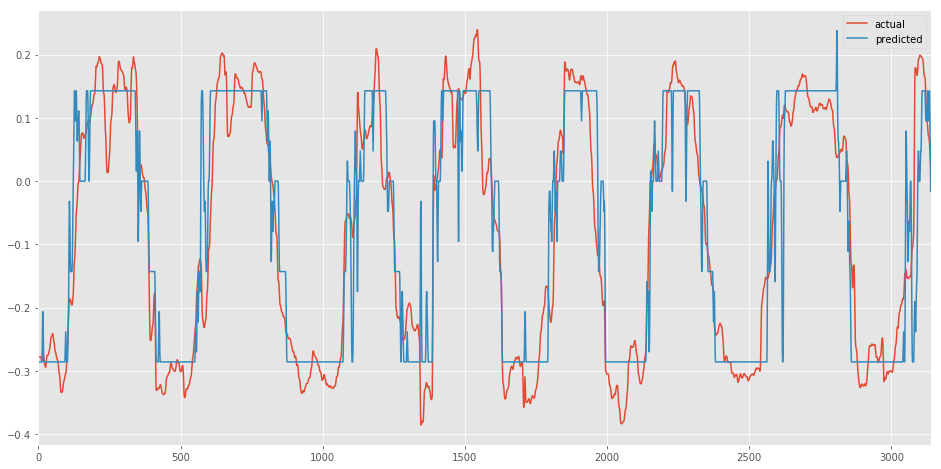

In [17]:
model = keras.models.load_model('models/ws.cls.nb.1.30')
dataset = dataset_from_tub("data.ws.test/tub_1_17-09-23", limit=-1)
predicted, actual = output_pair_cat(model, dataset)
df = pd.DataFrame(dict(predicted=predicted, actual=actual))
df = df.rolling(5, win_type='triang').mean()
df.plot()
np.absolute(df['actual'] - df['predicted']).mean()

In [16]:
# eval_ds = dataset_from_all_tubs("data.ws.test")
eval_ds = dataset_from_tub("data.ws.test/tub_1_17-09-23", limit=-1)
model = keras.models.load_model('models/ws.cls.nb.1.30')

model.evaluate(x={"img_in": eval_ds[0]},
          y={"angle_out": bin_angle_out(eval_ds[1]), "throttle_out": eval_ds[2]},
          batch_size=128,
          verbose=2)

Tub does exist


[0.8573345150092877, 0.95252450033951175, 0.0624858148156439]

0.059926065506840619

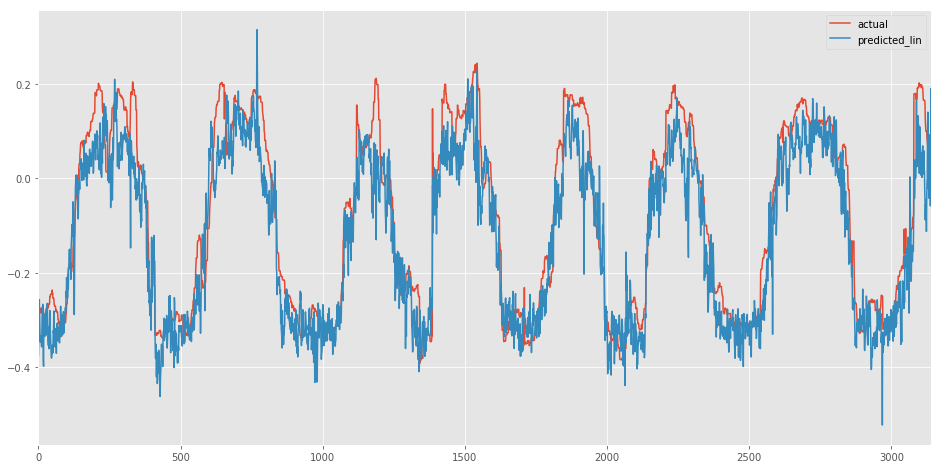

In [33]:
# dataset = dataset_from_all_tubs("data.ws.test")
# dataset = dataset_from_tub("data.ws.test/tub_1_17-09-23", limit=-1)
model = keras.models.load_model('models/ws.nb.3fc_l2.0.011')

predicted_lin, actual = output_pair_lin(model, dataset)
df = pd.DataFrame(dict(predicted_lin=predicted_lin[:,0], actual=actual))
# df = df.rolling(5, win_type='triang').mean()
df.plot()
np.absolute(df['actual'] - df['predicted_lin']).mean()